In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import os
import glob
import zipfile
from time import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#unzip data file
zip_path = "/content/segmentation_data.zip"
extract_path = "/content/data"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"Extracting {zip_path} to {extract_path}...")
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print(f"Directory {extract_path} already exists. Skipping extraction.")

images_path = "/content/data/dldata/Original Images/Original Images"
masks_path  = "/content/data/dldata/Original Masks/Original Masks"

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Extracting /content/segmentation_data.zip to /content/data...
Extraction complete.
Found 22 images and 22 masks


In [ ]:
#dataset and transformations

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]


        image = Image.open(img_path)
        mask = Image.open(mask_path)


        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

import numpy as np

#normalization
def normalize_image_transform(img):

    #convert PIL image to numpy array
    np_img = np.array(img, dtype=np.float32)

    min_val = np.min(np_img)
    max_val = np.max(np_img)

    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:

        normalized_img = np.zeros(np_img.shape, dtype=np.float32)


    return torch.from_numpy(normalized_img).unsqueeze(0)


image_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=10),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform)
])


mask_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=10),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img) <= 0).unsqueeze(0).float())
])


print("Visualizing samples from the Dataset (after transforms)...")
viz_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

#plot the first 3 samples
n_samples_to_plot = 3
plt.figure(figsize=(6, n_samples_to_plot * 4))

for i in range(n_samples_to_plot):

    image_tensor, mask_tensor = viz_dataset[i]

    #transformed Image
    plt.subplot(n_samples_to_plot, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Image\nShape: {image_tensor.shape}")
    plt.axis('off')

    #transformed mask
    plt.subplot(n_samples_to_plot, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- pixel Counts for a single mask (Sample 0) ---")
image_tensor, mask_tensor = viz_dataset[0]

pore_pixels = mask_tensor.sum().item()

total_pixels = mask_tensor.numel()
background_pixels = total_pixels - pore_pixels

pore_percentage = (pore_pixels / total_pixels) * 100
bg_percentage = (background_pixels / total_pixels) * 100

print(f"Analyzing Sample 0 (after transforms):")
print(f"Total Pixels: {int(total_pixels)}")
print(f"Pore (1.0) Pixels:   {int(pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Background (0.0) Pixels: {int(background_pixels)} ({bg_percentage:.2f}%)")

In [ ]:

#dataloaders and data split
full_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)


torch.manual_seed(42) #for reproducible splits
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

#dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created.")

In [ ]:
#sanity check
try:
    images, masks = next(iter(train_loader))
    print(f"Images batch shape: {images.shape}")
    print(f"Masks batch shape:  {masks.shape}")
    print(f"Mask tensor data type: {masks.dtype}")
    print(f"Mask min value: {masks.min()}")
    print(f"Mask max value: {masks.max()}")
    print(f"Unique mask values in batch: {torch.unique(masks)}")
except (StopIteration, NameError):
    print("ERROR")

In [6]:

#metrics

def dice_overlap(y_real, y_pred):
    intersection = torch.sum(torch.mul(y_real, y_pred))
    denominator = torch.sum(y_real) + torch.sum(y_pred)

    return (2 * intersection) / denominator


def intersection_over_union(y_real, y_pred):
    intersection = torch.sum(torch.mul(y_real, y_pred))
    union = torch.sum(y_real) + torch.sum(y_pred) - intersection

    return intersection/union


def accuracy(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    correct_predictions = torch.sum(y_real == y_pred)
    total_pixels = y_real.size(0)

    return correct_predictions.float() / total_pixels


def sensitivity(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    tp = torch.sum((y_real == 1) & (y_pred == 1))
    fn = torch.sum((y_real == 1) & (y_pred == 0))

    return tp / (tp + fn)


def specificity(y_real, y_pred):
    tn = torch.sum((y_real == 0) & (y_pred == 0))
    fp = torch.sum((y_real == 0) & (y_pred == 1))

    return tn / (tn + fp)

In [7]:
#loss functions

class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        return loss

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        p = torch.sigmoid(y_pred)
        if p.dim() == 3:
            p = p.unsqueeze(1)
            y_true = y_true.unsqueeze(1)
        elif y_true.dim() == 3:
            y_true = y_true.unsqueeze(1)
        N = p.shape[0]
        p_f = p.contiguous().view(N, -1)
        y_f = y_true.contiguous().view(N, -1)
        smooth = 1.0
        intersection = (p_f * y_f).sum(dim=1)
        denom = p_f.sum(dim=1) + y_f.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (denom + smooth)
        return (1.0 - dice).mean()


def focal_loss(y_real, y_pred, gamma_2=2.0):
    prob = torch.sigmoid(y_pred)
    pt = torch.where(y_real == 1, prob, 1 - prob)
    focal_loss = - (1 - pt) ** gamma_2 * torch.log(pt + 1e-8)

    return torch.mean(focal_loss)


import torch.nn.functional as F

def cross_entropy_weighted_loss(y_real, y_pred, pos_weight=1.0):
    y_pred = torch.sigmoid(y_pred)
    loss_fn = torch.nn.BCELoss(weight=(y_real * (pos_weight - 1) + 1))
    loss = loss_fn(y_pred, y_real)

    return loss


class FocalLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        bce = nn.functional.binary_cross_entropy_with_logits(y_pred, y_true, reduction="none")
        p = torch.sigmoid(y_pred)
        pt = p * y_true + (1 - p) * (1 - y_true)
        gamma = 2.0
        focal = torch.pow((1 - pt).clamp(min=1e-6), gamma)
        loss = focal * bce
        return loss.mean()

class BCELoss_TotalVariation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        x = torch.sigmoid(y_pred)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        dh = x[:, :, 1:, :] - x[:, :, :-1, :]
        dw = x[:, :, :, 1:] - x[:, :, :, :-1]
        regularization = dh.abs().mean() + dw.abs().mean()
        return loss + 0.1*regularization

In [18]:
#UNet model

class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)
        out = self.output_conv(d1)
        return out

In [19]:
for X_batch, y_batch in train_loader:
    print("X shape:", X_batch.shape, "dtype:", X_batch.dtype)
    print("y shape:", y_batch.shape, "dtype:", y_batch.dtype)
    print("y min/max:", y_batch.min().item(), y_batch.max().item())
    try:
        print("y unique (sample):", torch.unique(y_batch)[:10])
    except Exception:
        pass
    break

X shape: torch.Size([8, 1, 256, 256]) dtype: torch.float32
y shape: torch.Size([8, 1, 256, 256]) dtype: torch.float32
y min/max: 0.0 1.0
y unique (sample): tensor([0., 1.])


In [20]:
import random
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(SEED)

print(f"Reproducibility seed set to {SEED}")

#training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = UNet(in_channels=1, out_channels=1).to(device)
learning_rate = 0.001
#learning_rate = 1e-4
opt = optim.Adam(model.parameters(), learning_rate)

#loss
loss_fn = DiceLoss()
#loss_fn = BCELoss()
#loss_fn = focal_loss
#loss_fn = cross_entropy_weighted_loss
# loss_fn = BCELoss_TotalVariation()
print(f"Using loss function: {loss_fn.__class__.__name__}")
epochs = 50

#use more epochs for early stopping:
#epochs = 100


train_losses = []
val_losses = []

print("\nStarting training...")

for epoch in range(epochs):
    tic = time()


    model.train()
    avg_loss = 0
    avg_acc = 0

    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        opt.zero_grad()

        y_pred_logits = model(X_batch)
        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        opt.step()

        avg_loss += loss.item() / len(train_loader)


        y_pred = torch.sigmoid(y_pred_logits)
        y_pred_bin = (y_pred > 0.5).float()
        avg_acc += accuracy(y_true, y_pred_bin).item() / len(train_loader)

    #validation
    model.eval()
    avg_val_loss = 0
    avg_dice = 0
    avg_iou = 0
    avg_val_acc = 0
    avg_sens = 0
    avg_spec = 0

    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)

            y_pred_logits = model(X_batch)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)


            y_pred = torch.sigmoid(y_pred_logits)
            y_pred_bin = (y_pred > 0.5).float()


            avg_dice += dice_overlap(y_true, y_pred_bin).item() / len(val_loader)
            avg_iou += intersection_over_union(y_true, y_pred_bin).item() / len(val_loader)
            avg_val_acc += accuracy(y_true, y_pred_bin).item() / len(val_loader)
            avg_sens += sensitivity(y_true, y_pred_bin).item() / len(val_loader)
            avg_spec += specificity(y_true, y_pred_bin).item() / len(val_loader)

    toc = time()


    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Train Acc : {avg_acc:.4f}')
    print(f'  - Val Loss  : {avg_val_loss:.4f}')
    print(f'  - Val Dice  : {avg_dice:.4f}')
    print(f'  - Val IoU   : {avg_iou:.4f}')
    print(f'  - Val Acc   : {avg_val_acc:.4f}')
    print(f'  - Val Sens  : {avg_sens:.4f}')
    print(f'  - Val Spec  : {avg_spec:.4f}\n')

    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)


    #early_stopping(avg_val_loss)
    #if early_stopping.early_stop:
     #print("Early stopping triggered!")
     #break


Reproducibility seed set to 42
Using device: cuda
Using loss function: DiceLoss

Starting training...
* Epoch 01/50 (Time: 1.28s)
  - Train Loss: 0.7624
  - Train Acc : 0.4740
  - Val Loss  : 0.8133
  - Val Dice  : 0.2031
  - Val IoU   : 0.1130
  - Val Acc   : 0.1130
  - Val Sens  : 1.0000
  - Val Spec  : 0.0000

* Epoch 02/50 (Time: 1.21s)
  - Train Loss: 0.7256
  - Train Acc : 0.6216
  - Val Loss  : 0.8127
  - Val Dice  : 0.1208
  - Val IoU   : 0.0643
  - Val Acc   : 0.8910
  - Val Sens  : 0.0663
  - Val Spec  : 0.9960

* Epoch 03/50 (Time: 1.21s)
  - Train Loss: 0.6800
  - Train Acc : 0.6304
  - Val Loss  : 0.8175
  - Val Dice  : 0.0000
  - Val IoU   : 0.0000
  - Val Acc   : 0.8870
  - Val Sens  : 0.0000
  - Val Spec  : 1.0000

* Epoch 04/50 (Time: 1.26s)
  - Train Loss: 0.6646
  - Train Acc : 0.7089
  - Val Loss  : 0.9160
  - Val Dice  : 0.0000
  - Val IoU   : 0.0000
  - Val Acc   : 0.8870
  - Val Sens  : 0.0000
  - Val Spec  : 1.0000

* Epoch 05/50 (Time: 1.29s)
  - Train Loss: 0.

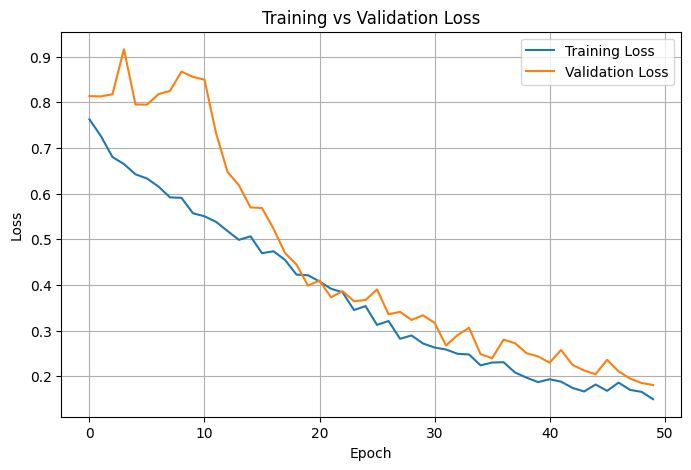

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#save model
# os.makedirs("results", exist_ok=True)
# torch.save(model.state_dict(), "results/EncDec_model.pth")
# print("\nTraining has finished! Model saved to results/EncDec_model.pth")

In [ ]:
#testing
model.eval()


def calculate_all_metrics_batch(preds, y_true, smooth=1e-6):

    preds_f = preds.contiguous().view(-1).float()
    y_f = y_true.contiguous().view(-1).float()


    tp = (preds_f * y_f).sum()
    fp = (preds_f * (1 - y_f)).sum()
    fn = ((1 - preds_f) * y_f).sum()
    tn = ((1 - preds_f) * (1 - y_f)).sum()
    total_pixels = y_f.numel()


    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    accuracy = (tp + tn) / total_pixels
    dice = (2.0 * tp + smooth) / (tp + fp + tp + fn + smooth)
    jaccard = (tp + smooth) / (tp + fp + fn + smooth)

    return precision.item(), recall.item(), accuracy.item(), dice.item(), jaccard.item()



print("\nStarting evaluation on the test set...")


total_precision = 0
total_recall = 0
total_accuracy = 0
total_dice = 0
total_jaccard = 0
total_pore_pixels = 0
total_bg_pixels = 0


with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)


        y_pred_logits = model(X_batch)


        y_pred_probs = torch.sigmoid(y_pred_logits)
        y_pred_binary = (y_pred_probs > 0.5).float()


        p, r, acc, d, j = calculate_all_metrics_batch(y_pred_binary, y_true)

        total_precision += p
        total_recall    += r
        total_accuracy  += acc
        total_dice      += d
        total_jaccard   += j



        batch_pores = y_true.sum().item()
        batch_total = y_true.numel()
        batch_bg = batch_total - batch_pores

        total_pore_pixels += batch_pores
        total_bg_pixels += batch_bg


num_batches = len(test_loader)
avg_precision = total_precision / num_batches
avg_recall    = total_recall / num_batches
avg_accuracy  = total_accuracy / num_batches
avg_dice      = total_dice / num_batches
avg_jaccard   = total_jaccard / num_batches

print(f"Test Set Results (Averaged over {num_batches} batches)")
print(f"Pixel Accuracy (Rand): {avg_accuracy * 100:.2f}%")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")
print(f"Precision:             {avg_precision:.4f}")
print(f"Recall (Sensitivity):  {avg_recall:.4f}")

print("\n Test Set Pixel Distribution (Ground Truth)")
total_pixels_all = total_pore_pixels + total_bg_pixels
pore_percentage = (total_pore_pixels / total_pixels_all) * 100
bg_percentage = (total_bg_pixels / total_pixels_all) * 100

print(f"Total Pixels (all test masks): {int(total_pixels_all)}")
print(f"Total Pore (Foreground) Pixels: {int(total_pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Total Background Pixels:        {int(total_bg_pixels)} ({bg_percentage:.2f}%)")



print("\nVisualizing some test predictions...")


X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

model.eval()
with torch.no_grad():
    y_pred_logits_viz = model(X_test_viz)
    y_pred_probs_viz = torch.sigmoid(y_pred_logits_viz)
    y_pred_binary_viz = (y_pred_probs_viz > 0.5).float()


X_test_cpu = X_test_viz.cpu()
y_test_cpu = y_test_viz.cpu()
y_pred_cpu = y_pred_binary_viz.cpu()


n_samples_to_plot = min(3, len(X_test_cpu))

plt.figure(figsize=(15, n_samples_to_plot * 5))
for i in range(n_samples_to_plot):


    plt.subplot(n_samples_to_plot, 3, i*3 + 1)
    plt.imshow(X_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Original Image")
    plt.axis('off')


    plt.subplot(n_samples_to_plot, 3, i*3 + 2)
    plt.imshow(y_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Ground Truth Mask")
    plt.axis('off')


    plt.subplot(n_samples_to_plot, 3, i*3 + 3)
    plt.imshow(y_pred_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()